In [1]:
import glob
import json
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import nibabel as nib
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix, plot_stat_map
import os
import pandas as pd
import pickle
import re

import sys
sys.path.append('/Users/zeynepenkavi/Documents/RangelLab/DescribedVsLearned_fmri/analysis/01_level1')
from level1_utils import run_level1

/Users/zeynepenkavi/.pyenv/versions/3.8.3/envs/py-dvl-fmri/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/Users/zeynepenkavi/.pyenv/versions/3.8.3/envs/py-dvl-fmri/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
data_path = '/Users/zeynepenkavi/Downloads/GTavares_2017_arbitration/bids_nifti_wface/'
behavior_path = '/Users/zeynepenkavi/Downloads/GTavares_2017_arbitration/behavioral_data/all_trials.csv'
out_path = os.path.join(data_path, "derivatives/nilearn/glm/level1/")

subnum = '01'

In [5]:
# run_level1(subnum, data_path, behavior_path, out_path)

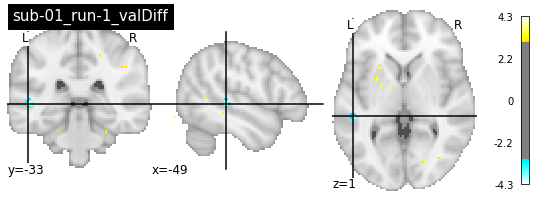

In [20]:
contrast_id = 'valDiff'
zmap = nib.load(os.path.join(out_path, 'sub-%s/contrasts/sub-%s_run-%s_%s.nii.gz'%(subnum, subnum, runnum, contrast_id)))
plot_stat_map(zmap, threshold=3.0, title='sub-%s_run-%s_%s' % (subnum, runnum, contrast_id))